In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 6)})
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import scipy.stats as scs

In [2]:
data = pd.read_csv('test.csv')

Файл test.csv содержит синтетические временные ряды. Каждая строка описывает состояние рынка в фиксированный момент времени (строки записаны в хронологическом порядке).

Сигналы {x1, ..., x8, y1} -- цены некоторых финансовых инструментов. Сигналы {s1, s2} -- вспомогательные сигналы. Модель ценообразования инструмента y1 скрыта. Известно, что значение y1[t] зависит от истории {x1, ..., x8}, а также s1 и s2.

In [3]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1
0,996.7459,1001.2642,999.1467,997.4923,999.7231,1000.8404,999.3012,998.4121,0.0,1.0,995.2712
1,996.6976,1001.2588,999.1436,997.5075,999.7024,1000.8533,999.3144,998.4018,0.0,1.0,995.2380
2,996.6631,1001.2644,999.1461,997.4998,999.7481,1000.8321,999.3057,998.4034,0.0,1.0,995.2146
3,996.6342,1001.2723,999.1480,997.5134,999.7333,1000.8421,999.2866,998.4075,0.0,1.0,995.1892
4,996.6195,1001.2735,999.1411,997.5150,999.7638,1000.8392,999.2458,998.4168,0.0,1.0,995.1890


In [4]:
# В данных нет пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      200000 non-null  float64
 1   x2      200000 non-null  float64
 2   x3      200000 non-null  float64
 3   x4      200000 non-null  float64
 4   x5      200000 non-null  float64
 5   x6      200000 non-null  float64
 6   x7      200000 non-null  float64
 7   x8      200000 non-null  float64
 8   s1      200000 non-null  float64
 9   s2      200000 non-null  float64
 10  y1      200000 non-null  float64
dtypes: float64(11)
memory usage: 16.8 MB


In [5]:
data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,s1,s2,y1
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1008.134596,1025.035793,999.260620,964.639790,1003.458776,1002.337918,991.419426,1007.265458,0.497585,0.492635,1000.569767
std,8.320269,13.284707,1.921541,14.535008,2.514194,2.332001,9.285440,3.795613,0.499995,0.499947,10.439449
min,992.325100,1000.095400,995.640500,935.809200,998.046500,997.274500,976.773000,997.779700,0.000000,0.000000,975.995900
25%,1001.973275,1012.776175,997.687875,951.858475,1001.579300,1000.541000,980.413575,1004.832975,0.000000,0.000000,994.712300
50%,1007.351750,1024.276650,999.243850,968.318800,1003.627300,1001.957700,992.325800,1007.234150,0.000000,0.000000,999.606550
75%,1012.614700,1036.769225,1000.311500,975.125825,1004.709700,1003.962500,1000.038000,1009.798825,1.000000,1.000000,1004.962125
max,1033.171200,1049.480900,1006.029700,1003.998000,1010.225800,1008.950700,1005.285200,1015.323100,1.000000,1.000000,1026.447300


## A. Первичная работа с данными

Признаки не являются нормально распределенными, т.е. при анализе корреляций необходимо использовать коэффициент корреляции Спирмена или Кендалла.

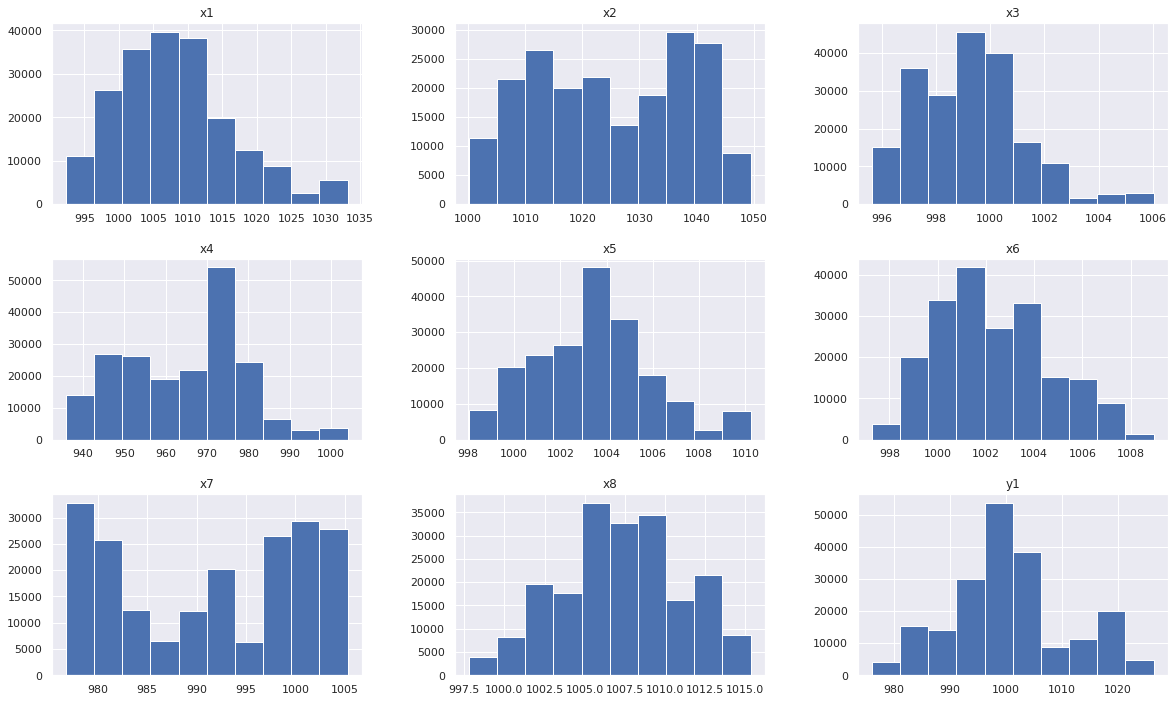

In [7]:
data.drop(['s1', 's2'], axis=1).hist(figsize=(20,12));

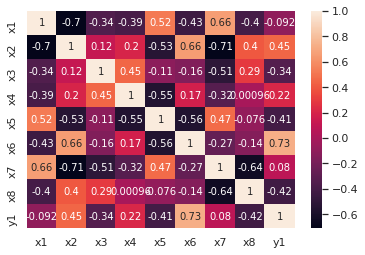

In [8]:
sns.heatmap(data.drop(['s1', 's2'], axis=1).corr('spearman'), annot=True);

Наибольшие зачения корреляции (больше 0.6):  
x6 w/ y1:  0.73;  
x2 w/ x6:  0.66;  
x1 w/ x7:  0.66;  
x1 w/ x2: -0.67;  
x7 w/ x8: -0.64;  
x2 w/ x7: -0.71.  

Сигналы x8 x5 x2 имеют корелляцию с y1 больше 0.4, т.е. их желательно оставить.  

Т.о., можно будет избавиться от сигналов x1 и x7 (во всяком случае сравнить станет ли модель точнее).

In [6]:
# Функция для построения графика и подсчета критерия Дики-Фуллера
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Построим графики рядов, автокорелляции и частичной автокорелляции, посчитаем Критерий Дики-Фуллера для всех данных.

Критерий Дики-Фуллера: p=0.123186
Критерий Дики-Фуллера: p=0.289394
Критерий Дики-Фуллера: p=0.876565
Критерий Дики-Фуллера: p=0.176606
Критерий Дики-Фуллера: p=0.381965
Критерий Дики-Фуллера: p=0.239912
Критерий Дики-Фуллера: p=0.934996
Критерий Дики-Фуллера: p=0.278762


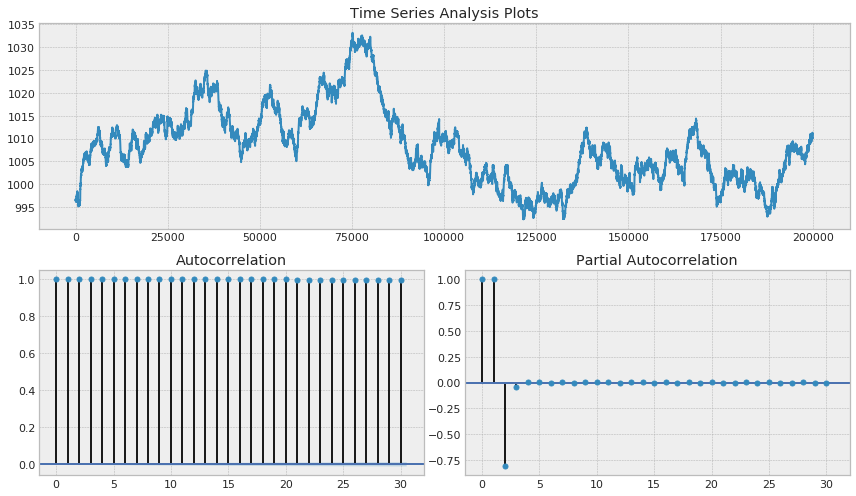

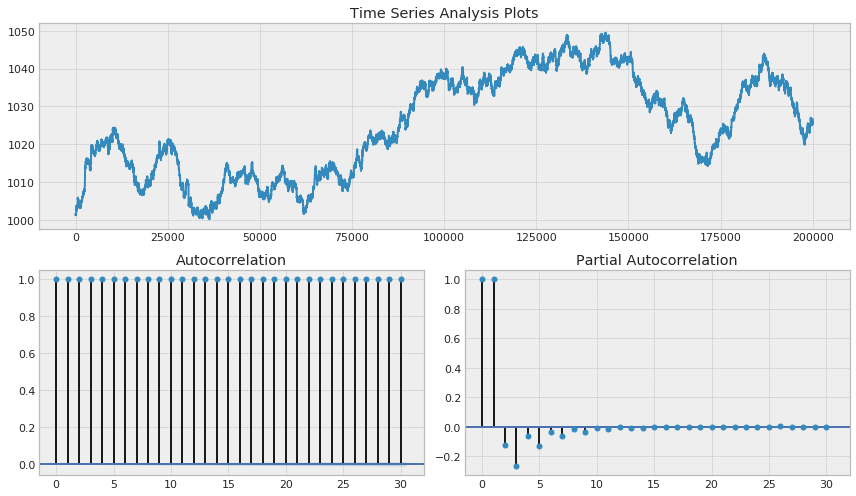

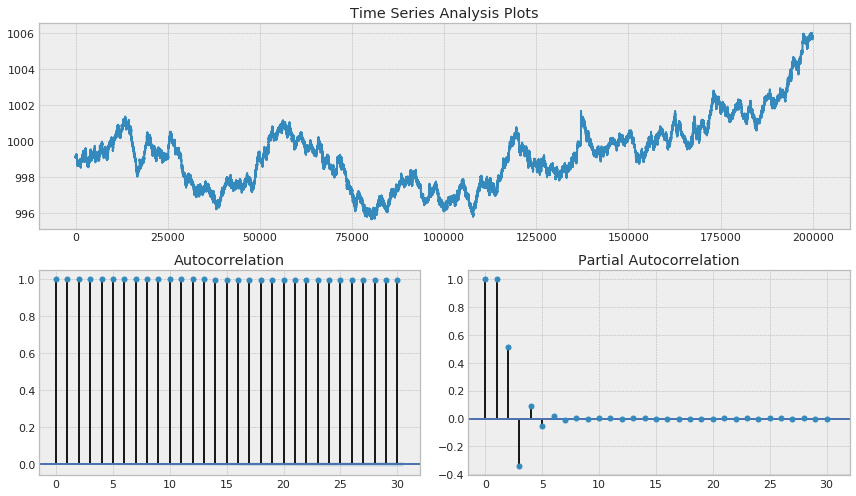

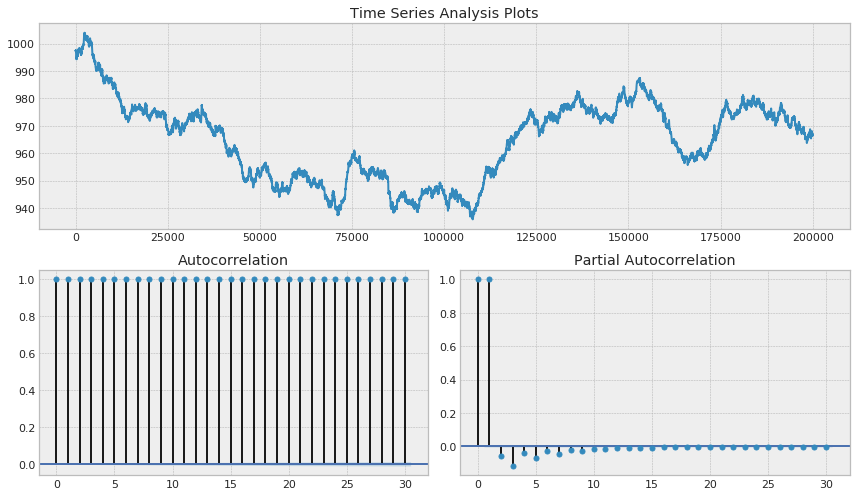

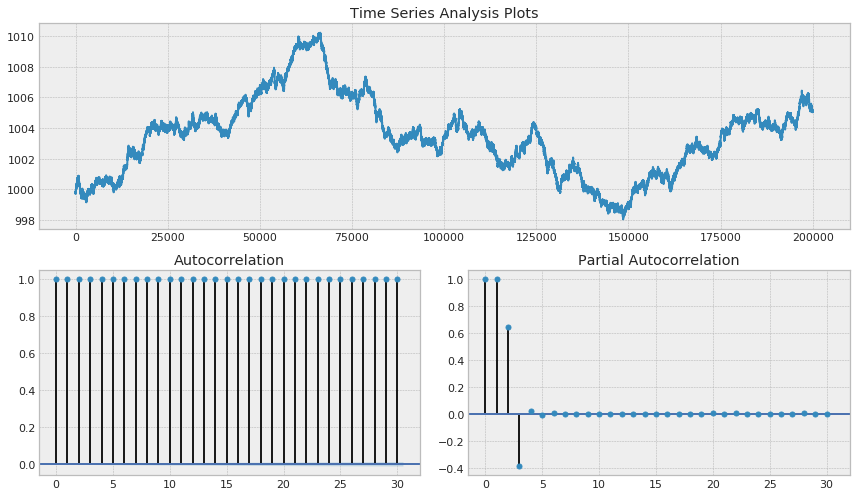

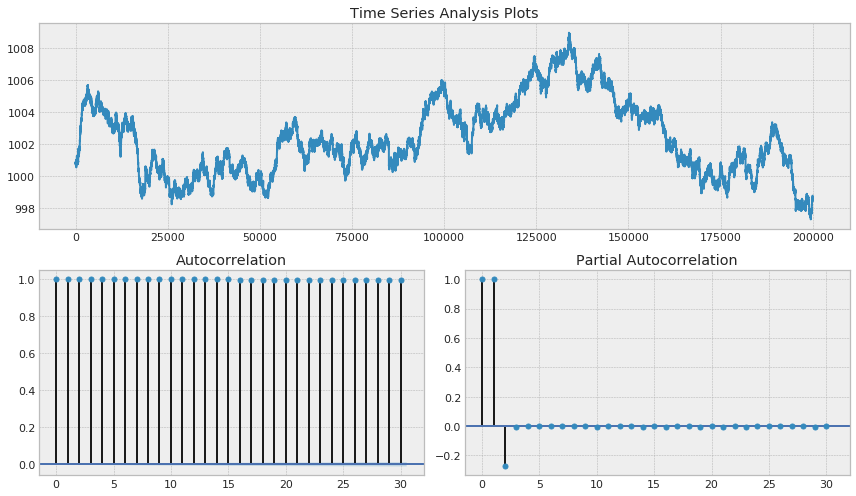

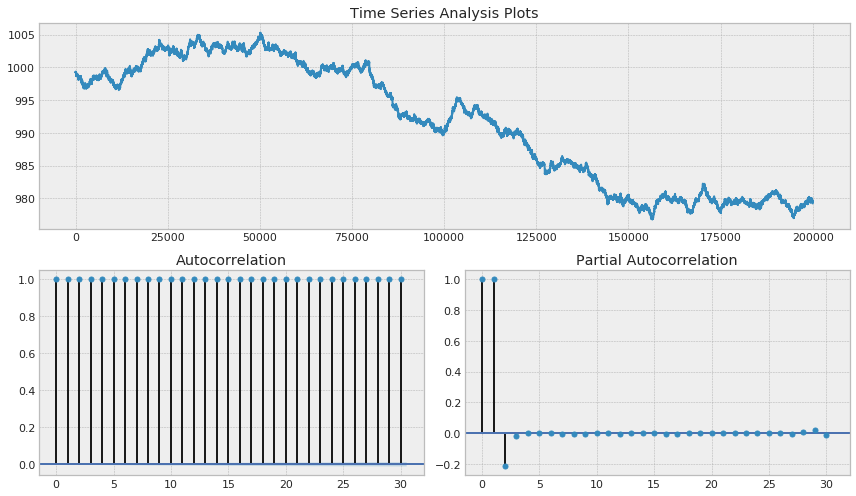

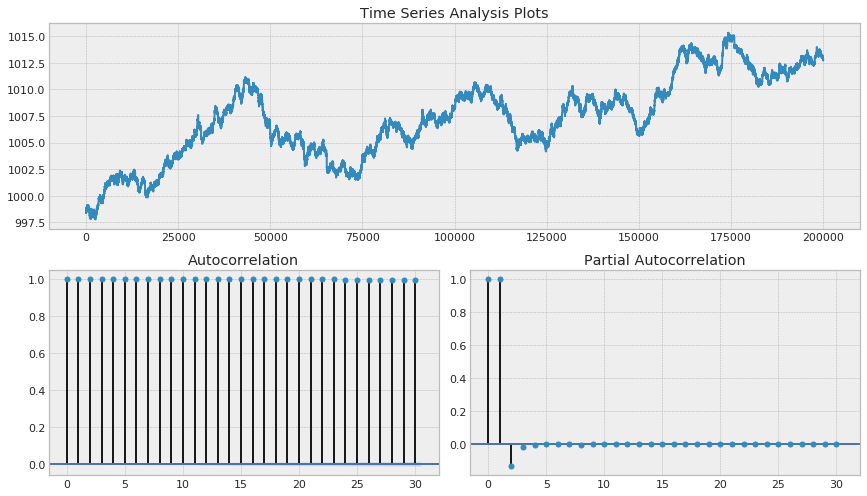

In [55]:
for i in range(1, 9):
    tsplot(data[f'x{i}'], lags=30)

Ни один из рядов не является стационарным.  
Сезонность отсутствует. 

Тогда попробуем взять первые разности.  

Критерий Дики-Фуллера: p=0.000000


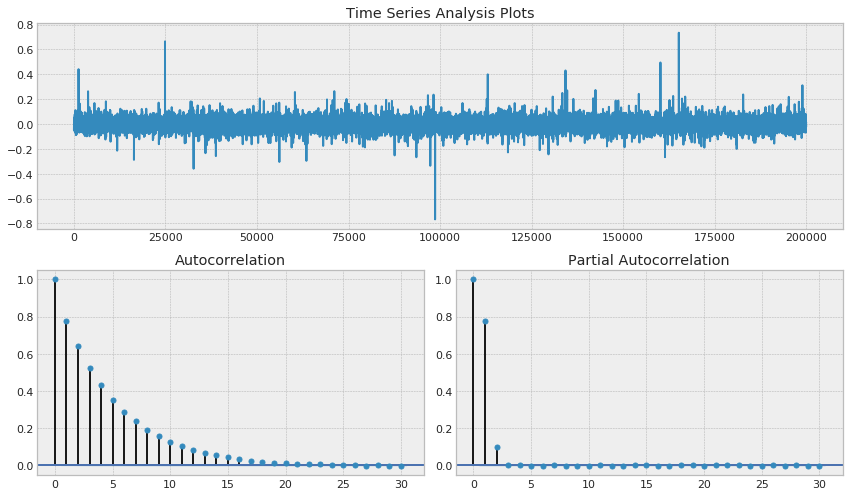

In [24]:
tsplot(data['x1'].diff(periods=1).dropna(), lags=30)

Ряд получился стационарным, но анализ автокорреляции и частичной автокорелляции говорят о том, 
что стоит взять еще раз первые разности от ряда, где уже взяли первые разности.

Критерий Дики-Фуллера: p=0.000000


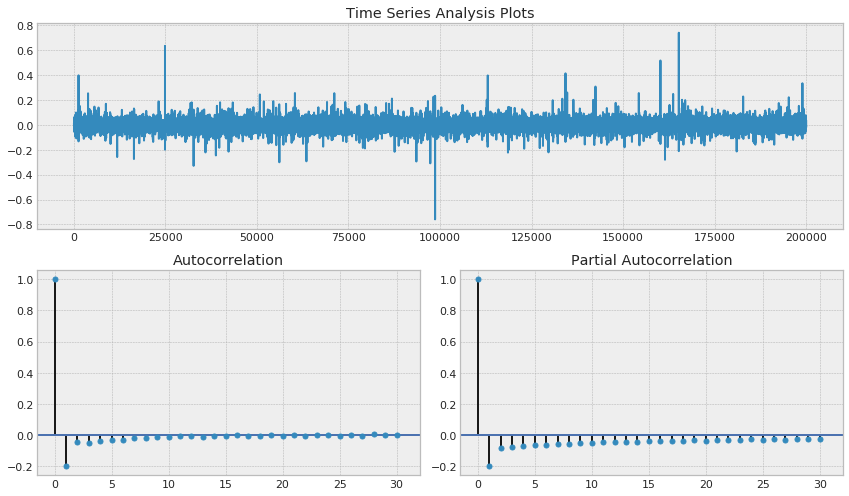

In [53]:
tsplot(data['x1'].diff(periods=1).dropna().diff(periods=1).dropna(), lags=30)

Получили стационарный ряд.  
Проделаем то же самое для остальных инструментов.

Критерий Дики-Фуллера: p=0.000000


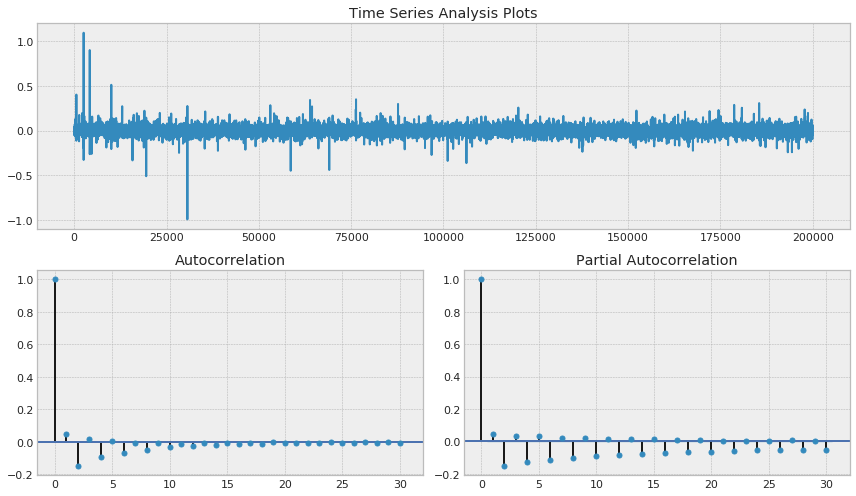

In [60]:
tsplot(data['x2'].diff(periods=1).dropna().diff(periods=2).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


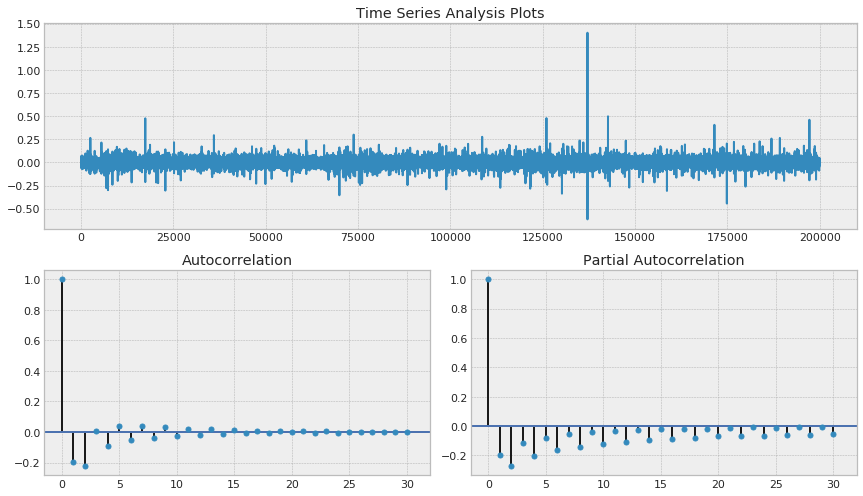

In [13]:
tsplot(data['x3'].diff(periods=1).dropna().diff(periods=2).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


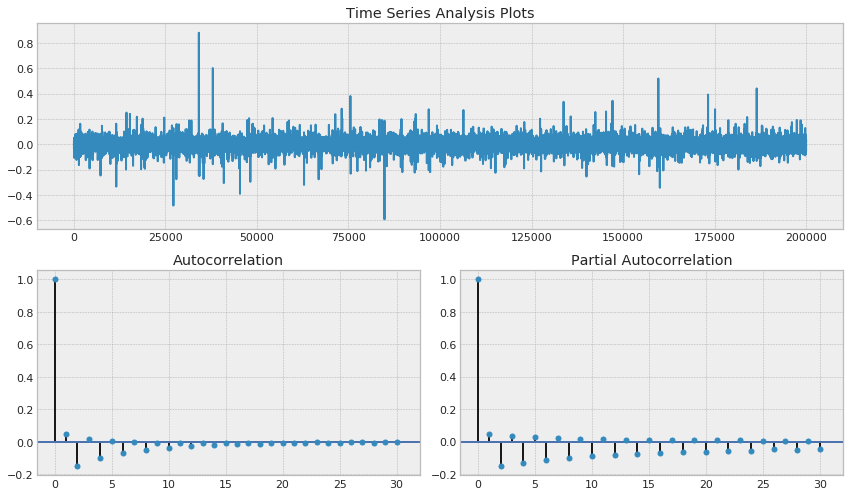

In [14]:
tsplot(data['x4'].diff(periods=1).dropna().diff(periods=2).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


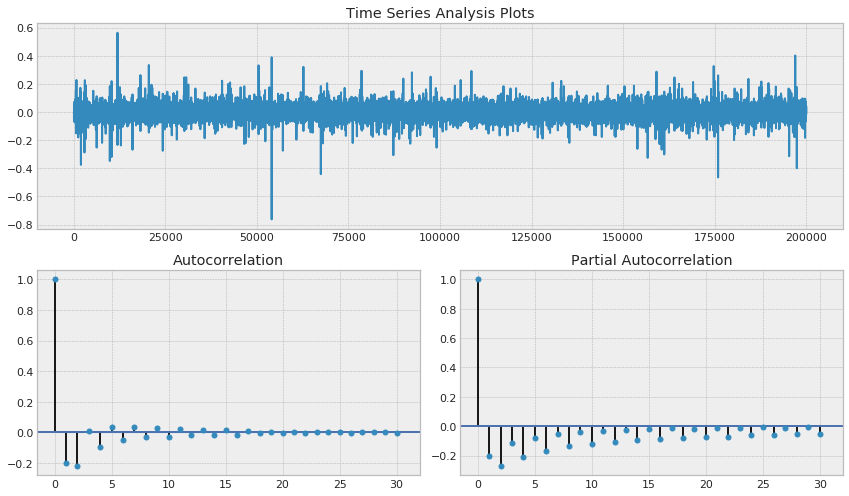

In [15]:
tsplot(data['x5'].diff(periods=1).dropna().diff(periods=2).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


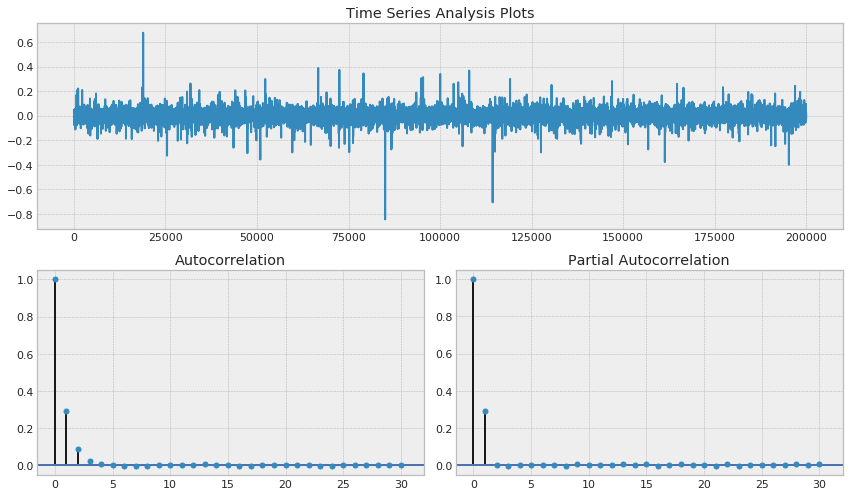

In [23]:
tsplot(data['x6'].diff(periods=1).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


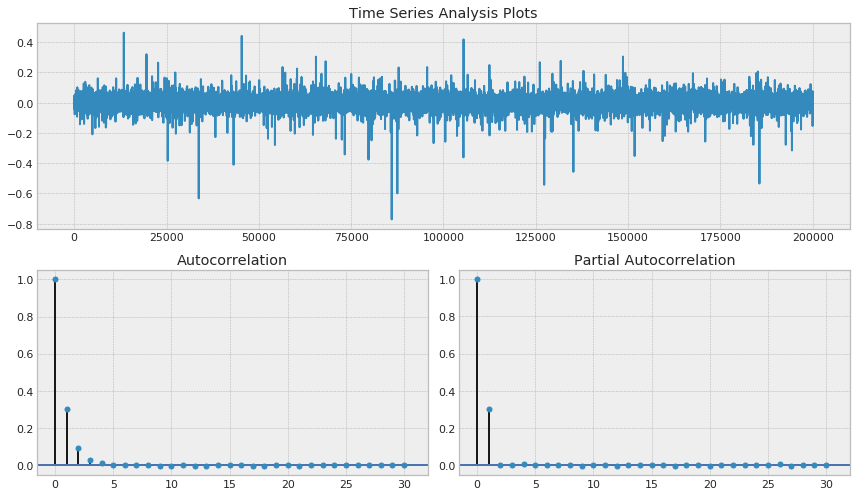

In [24]:
tsplot(data['x7'].diff(periods=1).dropna(), lags=30)

Критерий Дики-Фуллера: p=0.000000


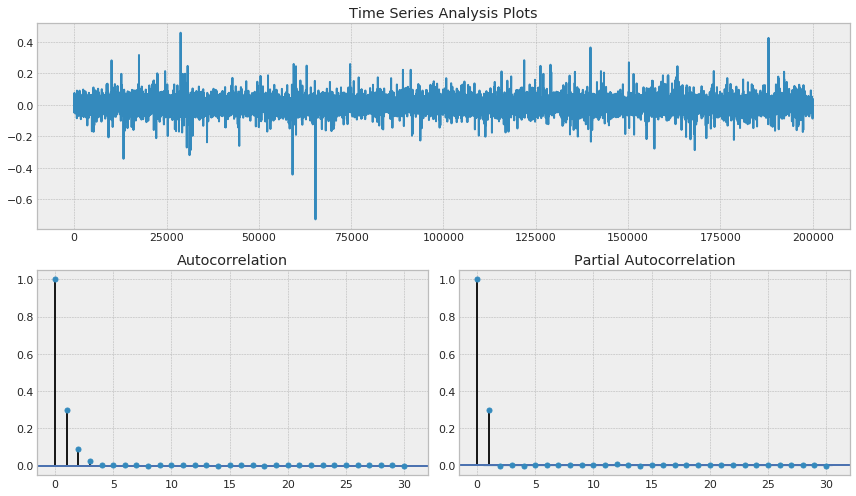

In [25]:
tsplot(data['x8'].diff(periods=1).dropna(), lags=30)

Чтобы оценить влияние сигналов на целевую переменную в зависимости от режиов рынка, 
можно взглянуть на корреляции сигналов при разных режимах.

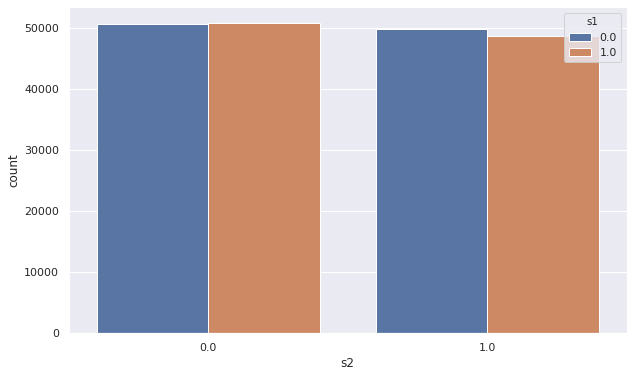

In [76]:
# Значения s1 и s2 сбаласированы.
sns.countplot(x='s2', hue='s1', data=data);

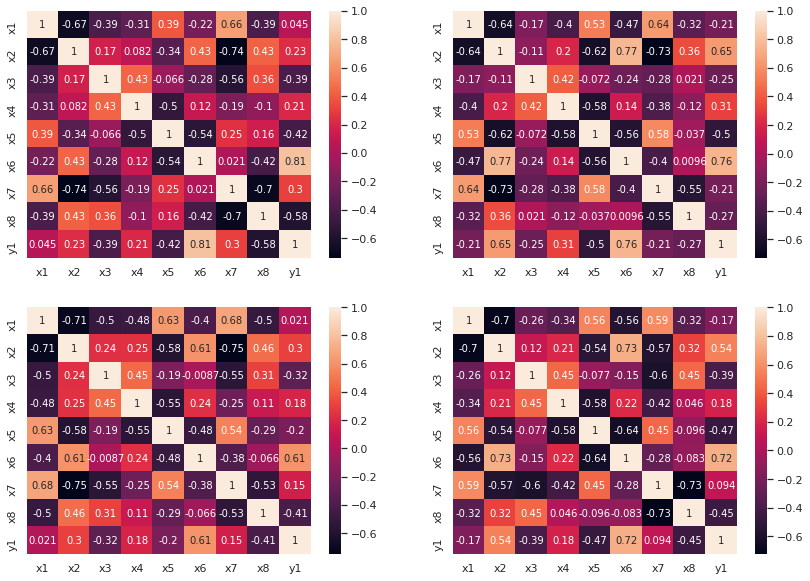

In [38]:
rcParams['figure.figsize'] = 14, 10
for i in range(0, 2):
    for j in range(0, 2):
        plt.subplot(220+2*i+j+1)
        sns.heatmap(data[(data['s1'] == i) & (data['s2'] == j)].drop(['s1', 's2'], axis=1).corr('spearman'), annot=True);

Сигнал x6 сохраняет наибольшее влияние на целевую переменную при любых режимах рынка.

In [7]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge

Для начала напишем простую функцию, которая бы строила прогноз на сырых данных  
Возьмем тестовый размер 0.001, будем строить прогноз примерно на 200 шагов вперед

In [14]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]

    return X_train, X_test, y_train, y_test

In [102]:
def evaluate(model, data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Mean absolute error {}".format((mean_absolute_error(y_test, prediction))))
    plt.grid(True);
    print(mean_absolute_error(y_test, prediction))

3.9132303979703624


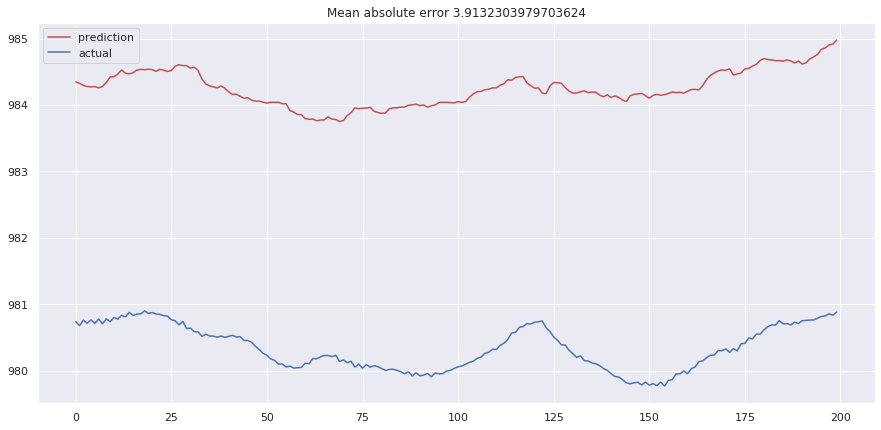

In [16]:
evaluate(LinearRegression(), data)

Получили среднюю абсолютную ошибку 3.9, что не очень хорошо

Попробуем изменить prepare_data и закодировать s1 и s2 средним значением y1 для каждого состояния рынка

In [20]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # Вместо s1 и s2 используем их комбинацию
    data['id'] = 2 * data['s1'] + data['s2']
    # Закодируем состояние рынка средним значением y1 для каждого состояния
    data = data.merge(data.groupby('id')['y1'].mean().reset_index(), on='id', how='left', suffixes=('', '_mean'))
    # Удалим закодированные средним признаки
    data.drop(['id', 's1', 's2'], axis=1, inplace=True)
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]

    return X_train, X_test, y_train, y_test

3.8586363295283603


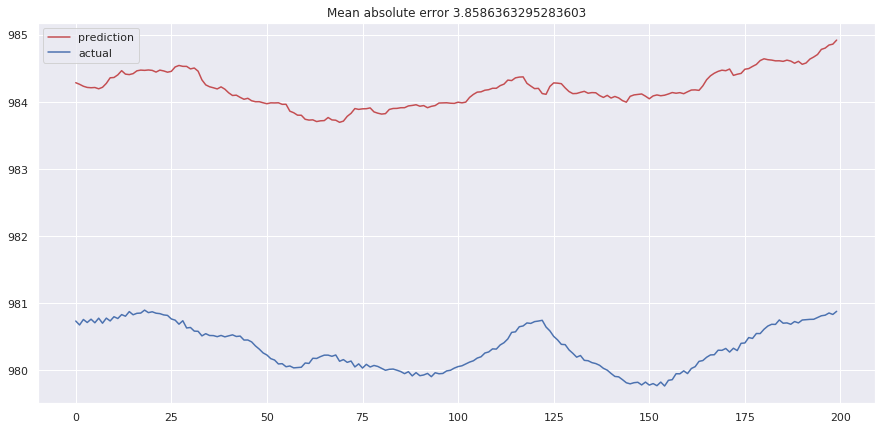

In [21]:
evaluate(LinearRegression(), data)

Ошибка незначительно снизилась

In [ ]:
# здесь я пробовал приводить ряды к 

# #data['x1'] = data['x1'].diff(periods=1).dropna()

# data['x1'] = data['x1'].diff(periods=1).dropna().diff(periods=1).dropna()

# data['x2'] = data['x2'].diff(periods=1).dropna().diff(periods=2).dropna()

# data['x3'] = data['x3'].diff(periods=1).dropna().diff(periods=2).dropna()

# data['x4'] = data['x4'].diff(periods=1).dropna().diff(periods=2).dropna()

# data['x5'] = data['x5'].diff(periods=1).dropna().diff(periods=2).dropna()

# data['x6'] = data['x6'].diff(periods=1).dropna()

# data['x7'] = data['x7'].diff(periods=1).dropna()

# data['x8'] = data['x8'].diff(periods=1).dropna()



Попробуем воспользоваться tsfresh и сгенерировать несколько фич

In [22]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # Вместо s1 и s2 используем их комбинацию
    data['id'] = 2 * data['s1'] + data['s2']
    
    # С помощью tsfresh сгенерируем несколько новых признаков
    extraction_settings = MinimalFCParameters()
    X = extract_features(data[:test_index].drop(['y1', 's1', 's2'], axis=1), column_id='id',
                     default_fc_parameters=extraction_settings, impute_function=impute)
    X['id'] = X.index
    data = data.merge(X, on='id', how='left')
    
    # Закодируем состояние рынка средним значением y1 для каждого состояния
    data = data.merge(data.groupby('id')['y1'].mean().reset_index(), on='id', how='left', suffixes=('', '_mean'))
    # Удалим закодированные средним признаки
    data.drop(['id', 's1', 's2'], axis=1, inplace=True)
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]

    return X_train, X_test, y_train, y_test

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 69.17it/s]


4.143209007812504


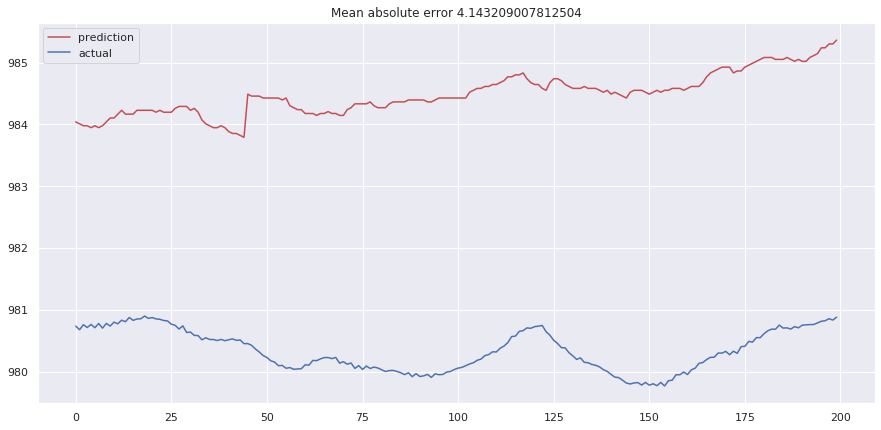

In [23]:
evaluate(LinearRegression(), data)

Ошибка выросла...

Ок, попробуем добавить в качестве признака изменение y1 со временем (например, на 50 лагов назад)

In [7]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # Вместо s1 и s2 используем их комбинацию
    data['id'] = 2 * data['s1'] + data['s2']
    
    # С помощью tsfresh сгенерируем несколько новых признаков
    extraction_settings = MinimalFCParameters()
    X = extract_features(data[:test_index].drop(['y1', 's1', 's2'], axis=1), column_id='id',
                     default_fc_parameters=extraction_settings, impute_function=impute)
    X['id'] = X.index
    data = data.merge(X, on='id', how='left')
    
    # Закодируем состояние рынка средним значением y1 для каждого состояния
    data = data.merge(data.groupby('id')['y1'].mean().reset_index(), on='id', how='left', suffixes=('', '_mean'))
    # Удалим закодированные средним признаки
    data.drop(['id', 's1', 's2'], axis=1, inplace=True)
    
    # Добавляем разницу на 50 лагов исходного ряда в качестве признаков
    for i in range(1, 50):
        data["lag_y1_{}".format(i)] = data.y1.shift(i)
        data['lag_y1_{}_diff'.format(i)] = data["lag_y1_{}".format(i)].diff()
        data.drop("lag_y1_{}".format(i), axis=1, inplace=True)
    
    data = data.dropna()
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]

    return X_train, X_test, y_train, y_test

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 82.64it/s]


4.170796898437504


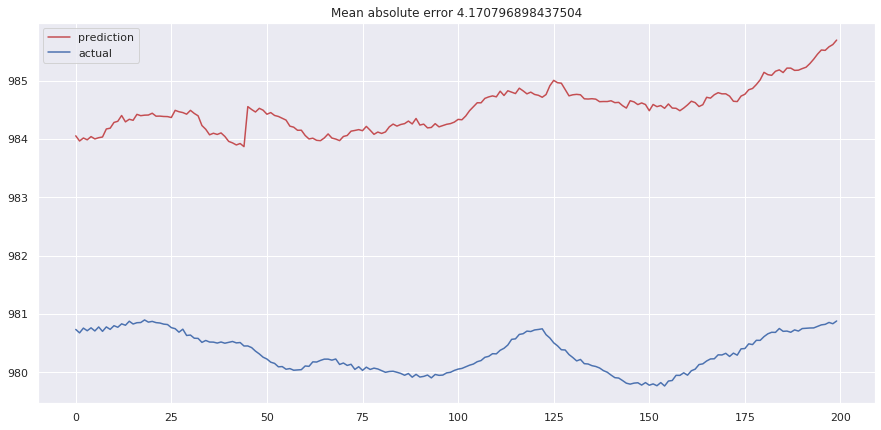

In [29]:
evaluate(LinearRegression(), data)

...

Надо взглянуть на коэффииенты, нет ли переобучения

In [16]:
def plotCoefficients(model, columns):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs[coefs['abs'] > 0.01]
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [104]:
def evaluate(model, data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Mean absolute error {}".format((mean_absolute_error(y_test, prediction))))
    plt.grid(True);
    print(mean_absolute_error(y_test, prediction))
    plotCoefficients(model, X_train.columns)

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 84.12it/s]


4.748594750000004


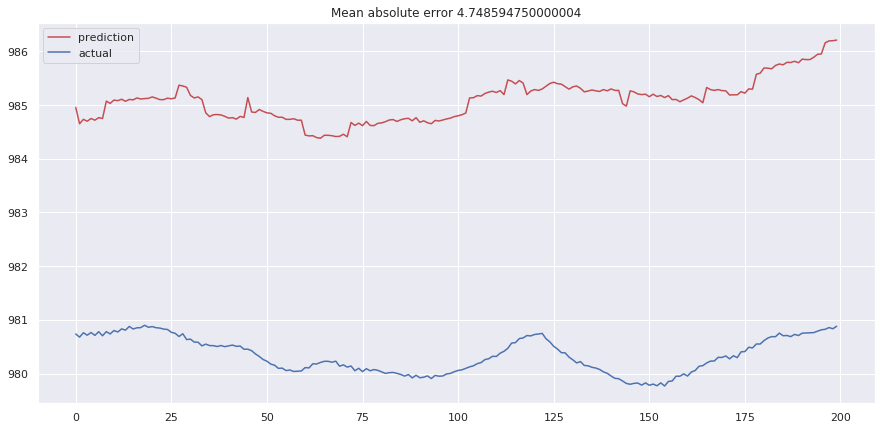

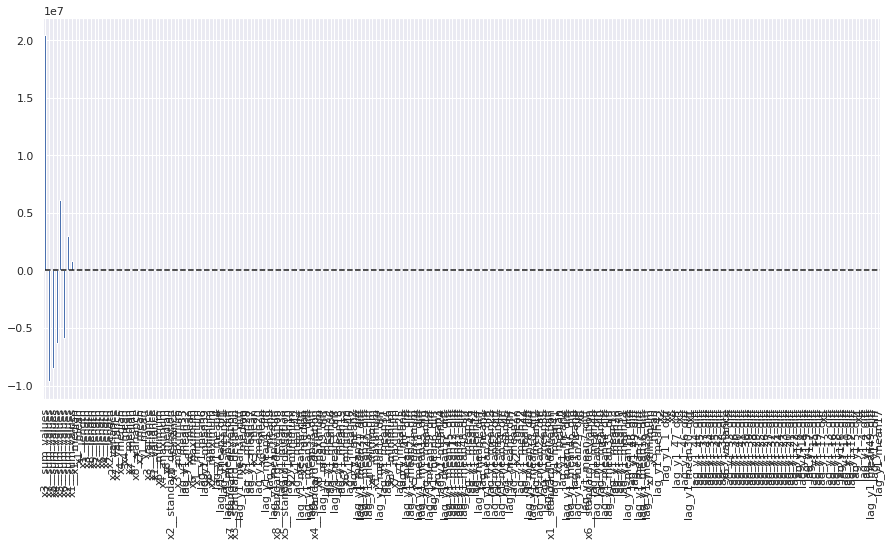

In [54]:
evaluate(LinearRegression(), data)

Налицо переобучение

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 84.95it/s]


4.112543277109376


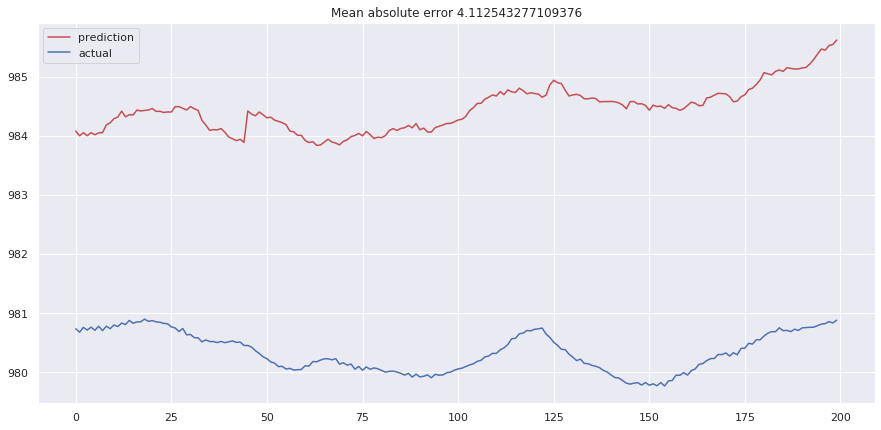

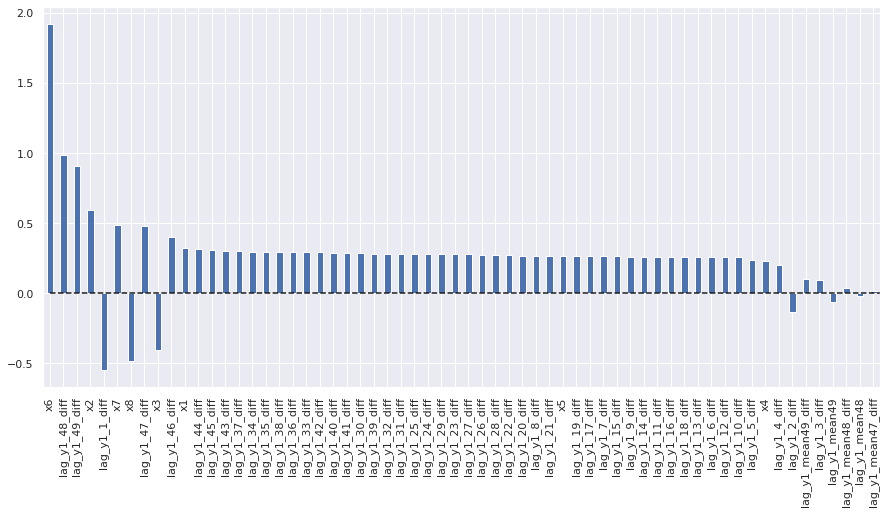

In [55]:
evaluate(Ridge(alpha=.9), data)

Ок, от переобучения избавились, но на ошибку это особо не повлияло

Вспоминаем, что в самом начале мы вычислили коррелирующие признаки, попробуем построить модель без них

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 106.35it/s]


0.5569884722654871


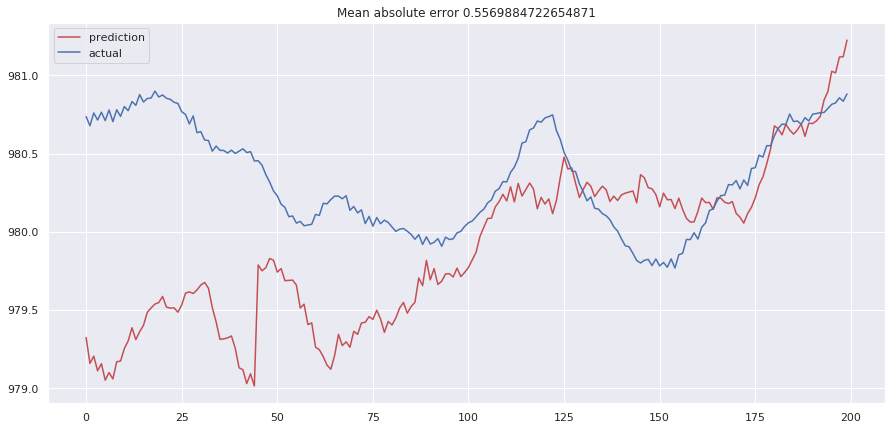

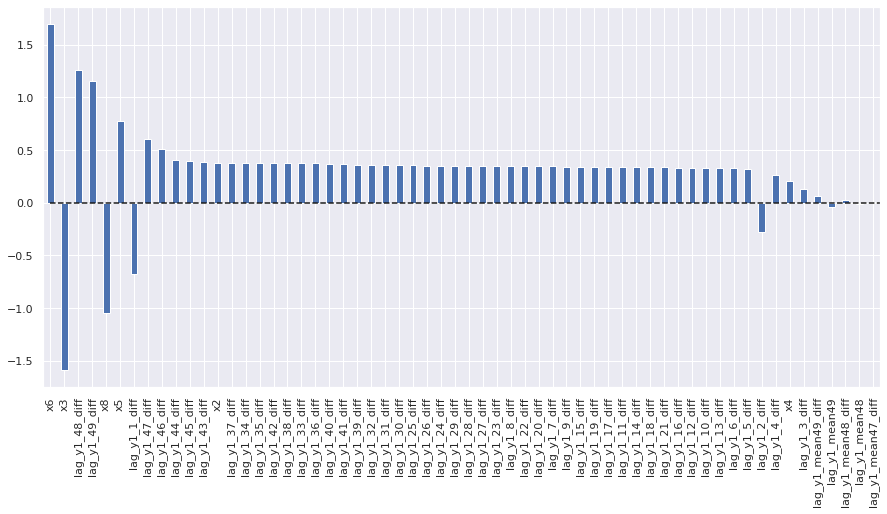

In [56]:
evaluate(Ridge(alpha=0.9), data.drop(['x1', 'x7'], axis=1))

Добавим еще лагов, мб 100  
И добавим информацию об изменении состояния рынка

In [23]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # Вместо s1 и s2 используем их комбинацию
    data['id'] = 2 * data['s1'] + data['s2']
    
    # С помощью tsfresh сгенерируем несколько новых признаков
    extraction_settings = MinimalFCParameters()
    X = extract_features(data[:test_index].drop(['y1', 's1', 's2'], axis=1), column_id='id',
                     default_fc_parameters=extraction_settings, impute_function=impute)
    X['id'] = X.index
    data = data.merge(X, on='id', how='left')

    # Закодируем состояние рынка средним значением y1 для каждого состояния
    data = data.merge(data.groupby('id')['y1'].mean().reset_index(), on='id', how='left', suffixes=('', '_mean'))

    # Добавляем разницу на 100 лагов исходного ряда в качестве признаков
    for i in range(1, 100):
        data["lag_y1_{}".format(i)] = data.y1.shift(i)
        data['lag_y1_{}_diff'.format(i)] = data["lag_y1_{}".format(i)].diff()
        data["lag_y1_mean{}".format(i)] = data.y1_mean.shift(i)
        data['lag_y1_mean{}_diff'.format(i)] = data["lag_y1_mean{}".format(i)].diff()
        data.drop("lag_y1_{}".format(i), axis=1, inplace=True)
    
    # Удалим закодированные средним признаки
    data.drop(['id', 's1', 's2'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]
    

    return X_train, X_test, y_train, y_test

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 105.25it/s]


0.25115880581714234


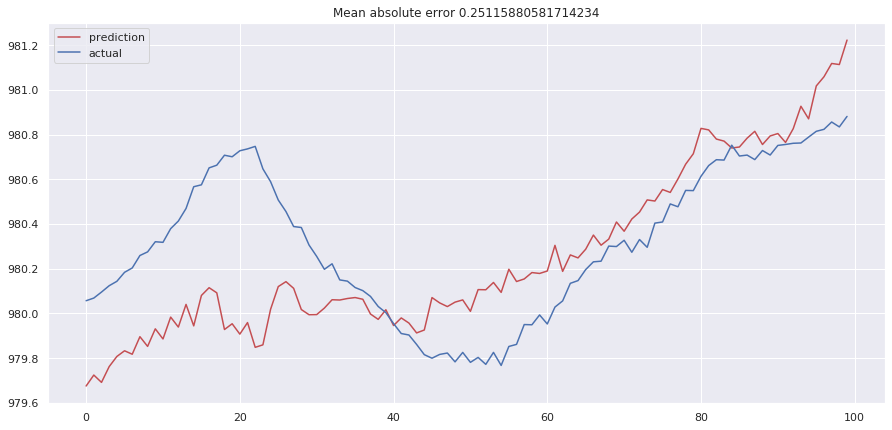

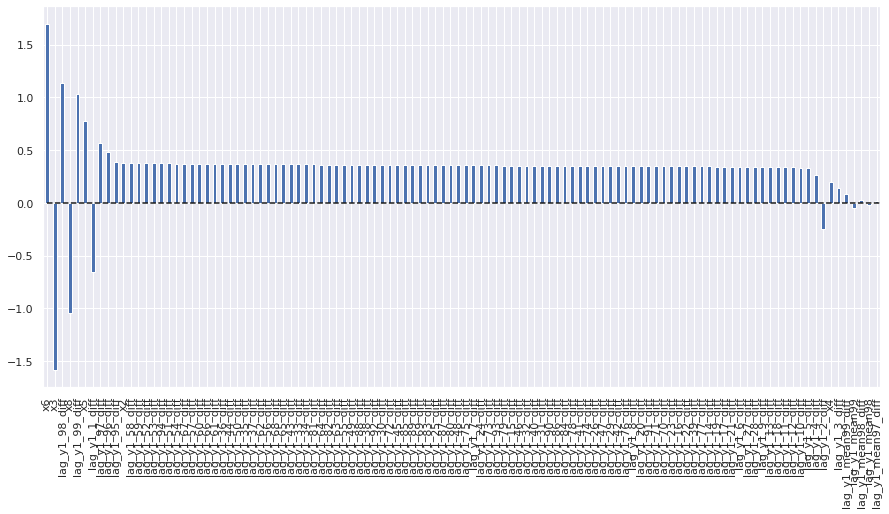

In [19]:
evaluate(Ridge(alpha=0.9), data.drop(['x1', 'x7'], axis=1))

Абсолютная ошибка 0.25, от этого можно уже отталкиваться  
Надо построить какой-то пайплайн для кросс-валидации, подобрать параметры модели, и понять какие признаки сыграли, а какие нет.

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Кросс-валидацию стоит проводить аккуратно, недопуская заглядываний вперед. 

In [49]:
X_train, X_test, y_train, y_test = prepare_data(data.drop(['x1', 'x7'], axis=1))

Feature Extraction: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


In [70]:
def get_cv(model, x, y, scoring=None, n_folds=10, test_size=0.001):
    scores = []
    step = int((len(x) - 1) / n_folds)
    #print(step)
    for i in range(0, n_folds):
        X_tr = x[i*step: int((i+1)*step - test_size*(i+1)*step)]
        Y_tr = y[i*step: int((i+1)*step - test_size*(i+1)*step)]
        X_tst = x[int((i+1)*step - test_size*(i+1)*step): (i+1)*step]
        Y_tst = y[int((i+1)*step - test_size*(i+1)*step): (i+1)*step]
        model.fit(X_tr, Y_tr)
        predict = model.predict(X_tst)
        scores.append(mean_absolute_error(Y_tst, predict))
    return np.mean(scores)

In [96]:
from tqdm.notebook import tqdm

In [97]:
best_res = 999
best_params = {}
for i in tqdm([1, .95, .9]):
    for j in tqdm([True, False]):
        for k in tqdm([True, False]):
            res = get_cv(Ridge(alpha=i, fit_intercept=j, normalize=k), X_train, y_train)
            if res < best_res:
                best_res = res
                best_params = {'alpha': i, 'fit_intercept': j, 'normalize' :k}

In [98]:
best_res, best_params

(1.16801239876468, {'alpha': 1, 'fit_intercept': False, 'normalize': True})

В итоге лучшая модель, что у меня получилась:

In [8]:
def evaluate(model, data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title("Mean absolute error {}".format((mean_absolute_error(y_test, prediction))))
    plt.grid(True);
    print(mean_absolute_error(y_test, prediction))
    plotCoefficients(model, X_train.columns)
    return (y_test - prediction)






Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 101.47it/s]


0.25115919807016324


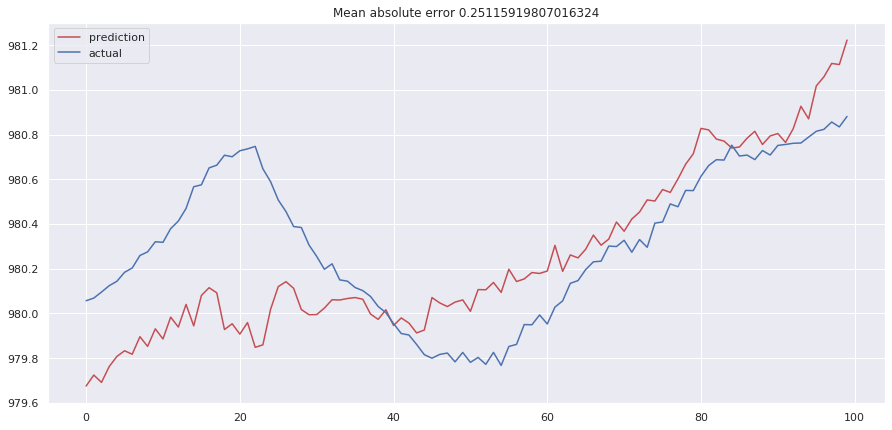

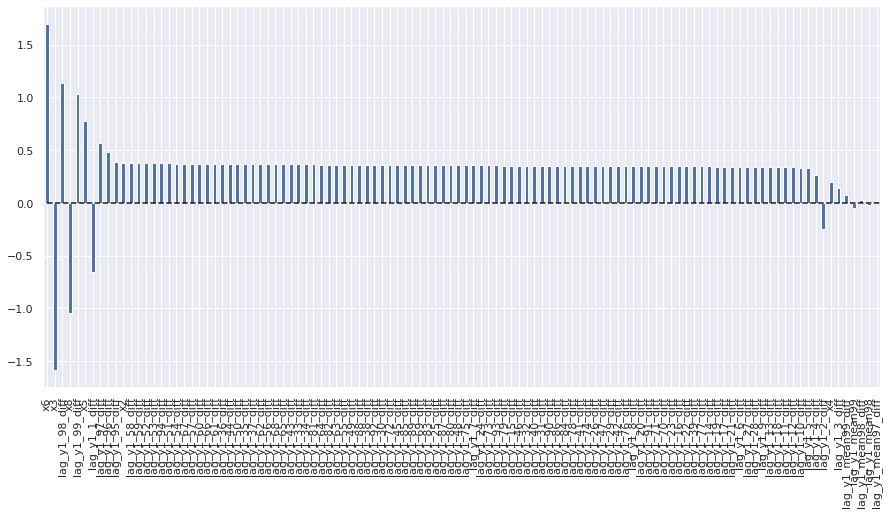

In [121]:
q = evaluate(Ridge(alpha=1, fit_intercept=False, normalize=True), data.drop(['x1', 'x7'], axis=1))

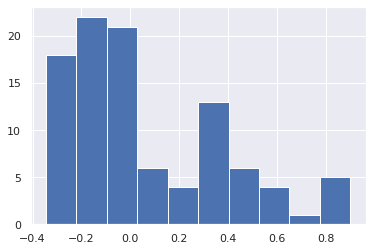

In [122]:
plt.hist(q);

In [124]:
np.mean(q)

0.063474237615535

Критерий Дики-Фуллера: p=0.634797


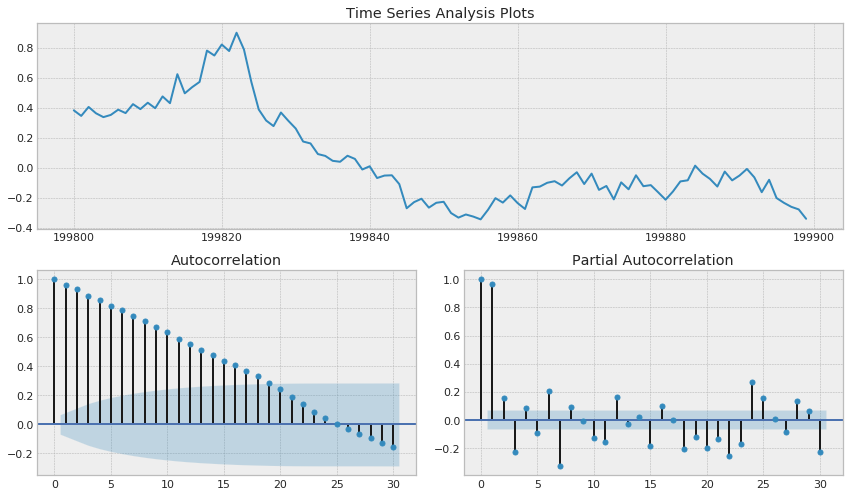

In [129]:
tsplot(q, lags=30)

Остатки  смещенные, нестационарны, автокореллированы, распределены ненормально.  
В общем, что-то пошло совсем не так.

Есть еще такая мысль: добавить в качестве признака само значение y1 на 100 лагов назад.  

In [130]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    # Вместо s1 и s2 используем их комбинацию
    data['id'] = 2 * data['s1'] + data['s2']
    
    # С помощью tsfresh сгенерируем несколько новых признаков
    extraction_settings = MinimalFCParameters()
    X = extract_features(data[:test_index].drop(['y1', 's1', 's2'], axis=1), column_id='id',
                     default_fc_parameters=extraction_settings, impute_function=impute)
    X['id'] = X.index
    data = data.merge(X, on='id', how='left')

    # Закодируем состояние рынка средним значением y1 для каждого состояния
    data = data.merge(data.groupby('id')['y1'].mean().reset_index(), on='id', how='left', suffixes=('', '_mean'))

    # Добавляем разницу на 100 лагов исходного ряда в качестве признаков
    for i in range(1, 100):
        data["lag_y1_{}".format(i)] = data.y1.shift(i)
        data['lag_y1_{}_diff'.format(i)] = data["lag_y1_{}".format(i)].diff()
        data["lag_y1_mean{}".format(i)] = data.y1_mean.shift(i)
        data['lag_y1_mean{}_diff'.format(i)] = data["lag_y1_mean{}".format(i)].diff()
        #data.drop("lag_y1_{}".format(i), axis=1, inplace=True)
    
    # Удалим закодированные средним признаки
    data.drop(['id', 's1', 's2'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]
    

    return X_train, X_test, y_train, y_test






Feature Extraction: 100%|██████████| 8/8 [00:00<00:00, 93.32it/s]A


0.024660699765634037


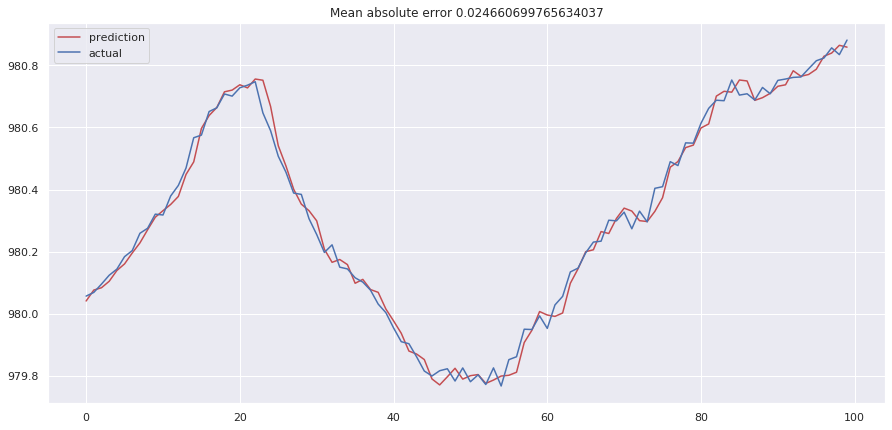

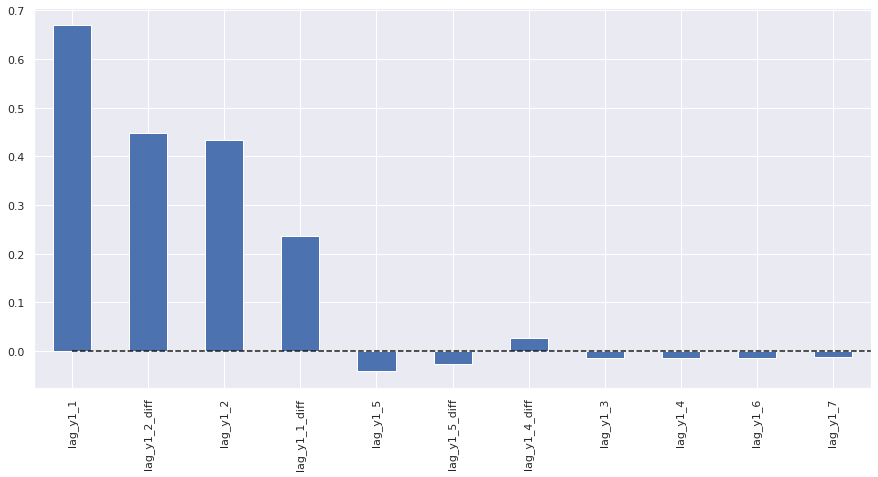

In [131]:
q = evaluate(Ridge(alpha=1, fit_intercept=False, normalize=True), data.drop(['x1', 'x7'], axis=1))

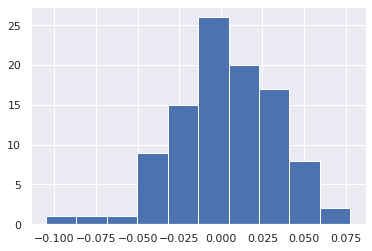

In [132]:
plt.hist(q);

In [133]:
np.mean(q)

0.002923074653394906

Критерий Дики-Фуллера: p=0.000000


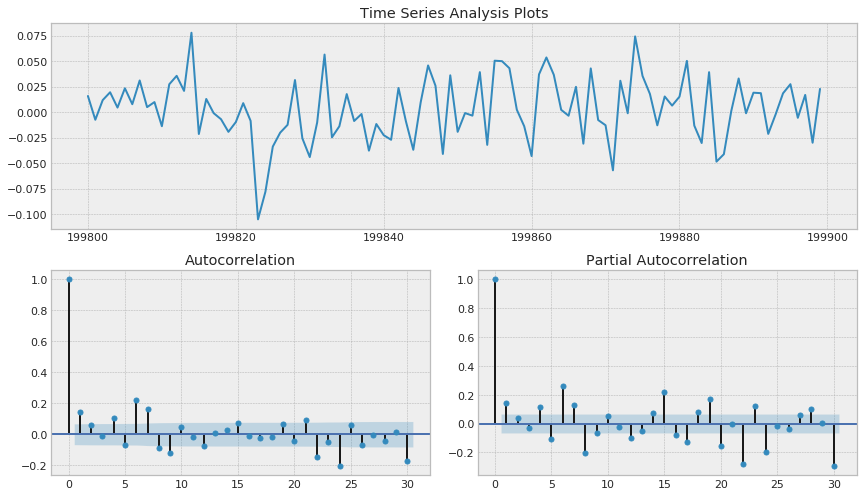

In [134]:
tsplot(q, lags=30)

Такая модель довольно точная, остатки это подтверждают. Мб так и надо было сразу сделать, но это как-то слишком просто, нет ли здесь подвоха?

Сравним с моделью, предсказывающую то же значение, что сейчас

In [9]:
def prepare_data(data, test_size=0.001):
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    
    X_train = data.loc[:test_index].drop(["y1"], axis=1)
    y_train = data.loc[:test_index]["y1"]
    X_test = data.loc[test_index:].drop(["y1"], axis=1)
    y_test = data.loc[test_index:]["y1"]

    return X_train, X_test, y_train, y_test

In [23]:
def evaluate(data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    #model.fit(X_train, y_train)
    #prediction = model.predict(X_test)
    prediction = np.append(np.array(y_train.values[-1]), y_test.values[:-1])
    prediction = prediction[100:]
    y_test=y_test[100:]
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    #plt.title("Mean absolute error {}".format((mean_absolute_error(y_test, prediction))))
    plt.grid(True);
    print(mean_absolute_error(y_test, prediction))
    #plotCoefficients(model, X_train.columns)
    return (y_test - prediction)

0.03671400000000176


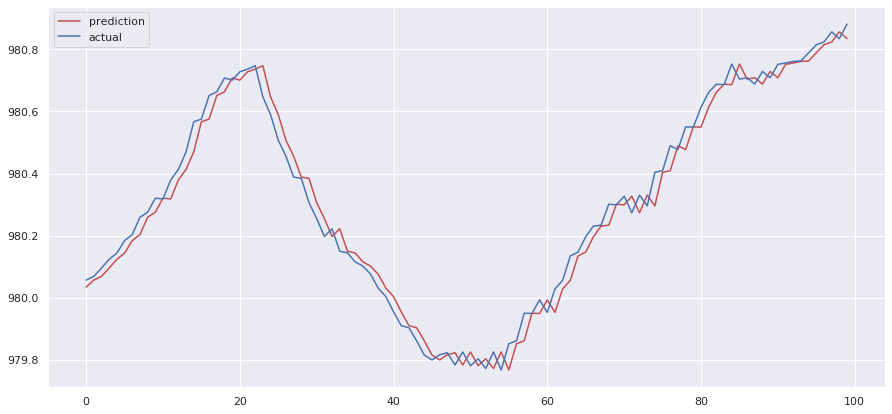

In [24]:
q = evaluate(data.drop(['x1', 'x7'], axis=1))

Ну, у меня даже поточнее вышло)  

Немного итогов:  
 - tsfresh не взлетел, может, потому что я испльзовал _MinimalFCParameters_, на большее у меня компьютер не вывез; 
 - приведение рядов к стационарным тоже не помогло, возможно, для обычной линейной модели это не так важно, как для fbprophet или ARIMA?
 - кодировние средним тоже не помогло, признак не дал прироста в качестве;
 - что дало результат: признак "изменение _y1_ 1..100 лагов назад" и "_y1_ 1..100 лагов назад" (хотя достаточно и 7-10 лагов);
 - очень помогло избавление от коррелирующих переменных; 
 - переход к линейной регрессии с регуляризацией (Ridge, Lasso избавлялся от большей части признаков);
 - подбор гиперпараметров модели и оценка на кросс-валидации; 

В тетрадке осветил только более-менее удачные эксперименты.  
И не очень понял как делать предикт на y[t+1], не имея данных о текущих сигналах (если я правильно понял задание вообще).  
Моя модель оказалась чуть лучше, чем та, что предсказывала бы просто текущее значение:(  
Естьу меня ощущения, я сделал что-то не то, есть куда расти и к чему стремиться. На ошибках учатся!